# Designing Floating Point Activation Functions


In [5]:
from typing import Type
import pyrtl
from pyrtl import *
import numpy as np
from enum import IntEnum
from hardware_accelerators.dtypes import *
from hardware_accelerators.rtllib import *
from hardware_accelerators.simulation import MatrixEngineSimulator

In [35]:
dtype = BF16
negative_minsubnormal = dtype(
    binint=dtype.min_subnormal().binint ^ (1 << dtype.bitwidth() - 1)
)
negative_minsubnormal

BF16(binary='1000000000000001', decimal=-9.183549615799121e-41, decimal_approx=-9.183549615799121e-41)

In [41]:
BF16.min_subnormal()

BF16(binary='0000000000000001', decimal=9.183549615799121e-41, decimal_approx=9.183549615799121e-41)

In [27]:
def flip_msb(number, bit_width):
    """Flips the most significant bit of a number.

    Args:
      number: The integer whose MSB needs to be flipped.
      bit_width: The number of bits in the binary representation of the number.

    Returns:
      The integer with its MSB flipped.
    """
    msb_mask = 1 << (bit_width - 1)  # Create a mask with only the MSB set
    return number ^ msb_mask  # XOR with the mask to flip the MSB


flip_msb(0b11000100, 8)

68

In [34]:
0 ^ 1

1

In [ ]:
config = AcceleratorConfig(
    array_size=4,
    data_type=BF16,
    weight_type=BF16,
    accum_type=BF16,
    pe_adder=float_adder,
    accum_adder=float_adder,
    pe_multiplier=float_multiplier,
    pipeline=True,
    accumulator_tiles=4,
)

In [27]:
# Load data
# weights = np.identity(config.array_size)
weights = np.ones((config.array_size, config.array_size))
activations = np.random.randn(config.array_size, config.array_size)

print(f"Original Weights:\n{weights}")
print(f"Original Activations:\n{activations}\n")

sim = MatrixEngineSimulator(config)
sim.load_weights(weights, bank=0)
sim.load_activations(activations, bank=0)

sim.matmul(data_bank=0, weight_bank=0, accum_tile=3, accumulate=False)
result = sim.accumulator_memory[3][::-1]

Original Weights:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Original Activations:
[[-0.07138086  1.62840722  0.79021196  0.60445009]
 [-0.66921776  0.79774217  1.49242775 -0.87192213]
 [ 0.16508374  1.81670144 -0.64583338  1.02154732]
 [ 0.3153564  -1.25524678  0.2251366  -0.33790754]]



In [28]:
true_result = activations @ weights

print(f"Result: \n{np.array2string(result, precision=2)}")
print(f"True Result: \n{np.array2string(true_result, precision=2)}")

np.isclose(result, true_result, rtol=1e-2)

Result: 
[[ 2.94  2.94  2.94  2.94]
 [ 0.75  0.76  0.84  0.75]
 [ 2.34  2.34  2.34  2.34]
 [-1.05 -1.05 -1.05 -1.05]]
True Result: 
[[ 2.95  2.95  2.95  2.95]
 [ 0.75  0.75  0.75  0.75]
 [ 2.36  2.36  2.36  2.36]
 [-1.05 -1.05 -1.05 -1.05]]


array([[ True,  True,  True,  True],
       [ True, False, False,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

# Numpy Experiments


In [ ]:
w = np.random.randn(4, 4)
x = np.array([1, 2, 3, 4]).reshape(-1, 1)
w, x

(array([[-1.9974601 , -1.12347142,  1.55653695, -2.59439844],
        [ 1.48185611,  1.63185189, -0.97048642, -0.39629033],
        [-0.18205327,  2.48082545,  2.86318036,  1.25190879],
        [-0.37553198, -0.71098343, -0.59694238,  0.37697322]]),
 array([[1],
        [2],
        [3],
        [4]]))

In [ ]:
w2 = np.random.randn(8, 4)
w2

array([[-0.02150474, -1.52106855, -0.3295202 ,  3.01362761],
       [ 1.76016379,  0.6241492 , -0.23567257,  0.02703748],
       [ 0.62486001, -1.93325829, -1.09121925,  0.54682745],
       [-0.576591  , -0.05988961, -1.23165852,  1.57575244],
       [-0.67036654,  0.66783024,  0.2138347 , -0.7086684 ],
       [ 0.95164216, -1.66634253, -2.06546421,  0.26354344],
       [ 0.95707405, -0.18376094,  0.98993361,  2.1474629 ],
       [-0.68926894,  1.35535676, -0.93757739,  1.77649634]])

In [ ]:
w2 @ x

array([[ 8.00230802],
       [ 2.40959441],
       [-4.32800452],
       [ 1.91166398],
       [-1.52787554],
       [-7.52326178],
       [12.14920459],
       [ 6.31469776]])

In [ ]:
np.pad(x, ((0, 0), (3, 0)), "constant", constant_values=(0,)).T

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 2, 3, 4]])

In [214]:
a = np.pad(x, ((0, 0), (3, 0)), "constant", constant_values=(0,)).T
sim_result = MatrixEngineSimulator.calculate_matmul(weights=w2[:4].T, data=a)

print(np.array2string(sim_result, precision=2, suppress_small=True))

[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [8.   2.41 2.16 1.94]]


In [215]:
sim_result = MatrixEngineSimulator.calculate_matmul(weights=w2[4:].T, data=a)

print(np.array2string(sim_result, precision=2, suppress_small=True))

[[ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [-1.53 -0.88 12.12  6.31]]


In [ ]:
w2 @ x.T.flatten()

array([ 8.00230802,  2.40959441, -4.32800452,  1.91166398, -1.52787554,
       -7.52326178, 12.14920459,  6.31469776])

In [ ]:
w @ x, x @ w.T

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 1)

In [171]:
a = np.pad(x, (0, 12), "constant", constant_values=(0,))
a = a.reshape(4, 4)
a

ValueError: cannot reshape array of size 208 into shape (4,4)

In [ ]:
w @ a.T

array([[ 0.91768077,  1.83536153,  2.7530423 ,  3.67072307],
       [-1.02687818, -2.05375636, -3.08063455, -4.10751273],
       [-0.11296584, -0.22593168, -0.33889752, -0.45186336],
       [ 0.26174055,  0.52348111,  0.78522166,  1.04696222]])

In [146]:
print(f"{w@a=}\n")
print(f"{a@w.T=}\n")
print(f"{a.T@w.T=}\n")

w@a=array([[-1.84034158,  0.        ,  0.        ,  0.        ],
       [-6.30369247,  0.        ,  0.        ,  0.        ],
       [-4.52667255,  0.        ,  0.        ,  0.        ],
       [-1.73104632,  0.        ,  0.        ,  0.        ]])

a@w.T=array([[ 0.91768077, -1.02687818, -0.11296584,  0.26174055],
       [ 1.83536153, -2.05375636, -0.22593168,  0.52348111],
       [ 2.7530423 , -3.08063455, -0.33889752,  0.78522166],
       [ 3.67072307, -4.10751273, -0.45186336,  1.04696222]])

a.T@w.T=array([[-1.84034158, -6.30369247, -4.52667255, -1.73104632],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])



In [ ]:
a.T @ w.T, a @ w, w @ a

(array([[-1.84034158, -6.30369247, -4.52667255, -1.73104632],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]),
 array([[ 0.91768077,  0.54640252, -0.89879807, -0.2886083 ],
        [ 1.83536153,  1.09280505, -1.79759614, -0.5772166 ],
        [ 2.7530423 ,  1.63920757, -2.6963942 , -0.8658249 ],
        [ 3.67072307,  2.1856101 , -3.59519227, -1.1544332 ]]),
 array([[-1.84034158,  0.        ,  0.        ,  0.        ],
        [-6.30369247,  0.        ,  0.        ,  0.        ],
        [-4.52667255,  0.        ,  0.        ,  0.        ],
        [-1.73104632,  0.        ,  0.        ,  0.        ]]))

In [ ]:
w.T @ x

array([[-1.0820356 ],
       [ 6.73877498],
       [ 5.81733566],
       [ 1.87664015]])

In [191]:
a.T

array([[1, 2, 3, 4],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [184]:
sim_result = MatrixEngineSimulator.calculate_matmul(weights=w, data=a.T)

print(np.array2string(sim_result, precision=2, suppress_small=True))

[[-1.92  6.72  5.78  1.88]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.  ]]


In [ ]:
a = np.array([1, 2, 3, 4])
a = np.pad(x.reshape(-1, 1), ((0, 0), (0, 3)), "constant", constant_values=0)
# a = np.pad(a.reshape(-1,1), ((0,0),(0,3)), 'constant', constant_values=0)
a

array([[1, 0, 0, 0],
       [2, 0, 0, 0],
       [3, 0, 0, 0],
       [4, 0, 0, 0]])

# ReLU Unit


---


In [304]:
def opt_relu(x: WireVector, enable: WireVector, valid: WireVector):
    pass_condition = valid & (~enable | (enable & ~x[-1]))
    return select(pass_condition, x, Const(0, x.bitwidth))


reset_working_block()
x = Input(16, "x")
out = Output(16, "out")
en, val = Input(1, "en"), Input(1, "val")
# out <<= relu(x)
# out <<= conditional_relu(x, en, val)
out <<= opt_relu(x, en, val)
sim = Simulation()

value = 5

sim.step({"x": BF16(value).binint, "en": 1, "val": 0})  # -6 in 2's complement
result = float(BF16(binint=sim.inspect(out.name)))
result

0.0

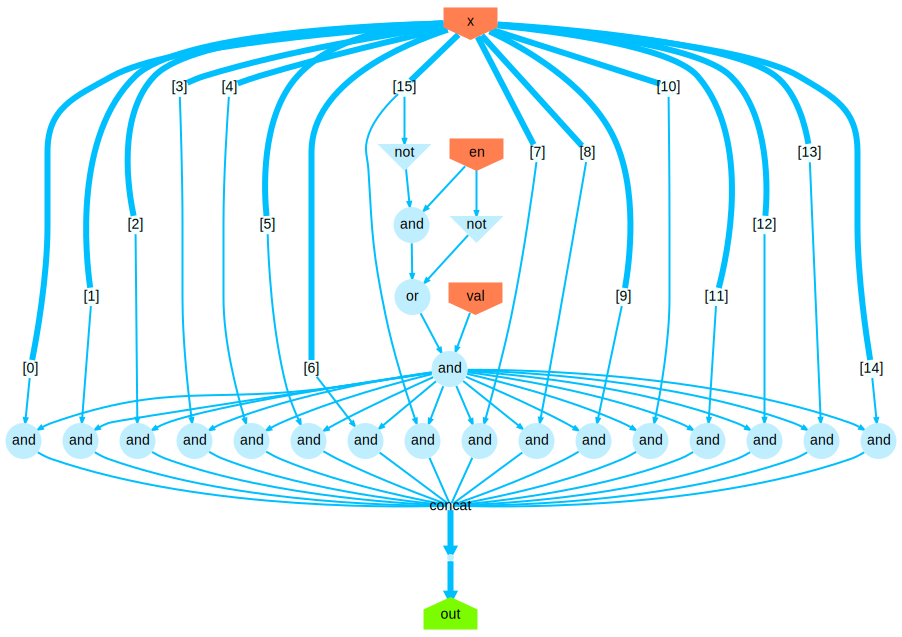

In [305]:
synthesize()
optimize()
working_block()

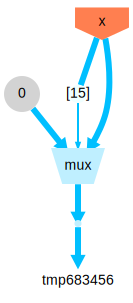

In [251]:
working_block()

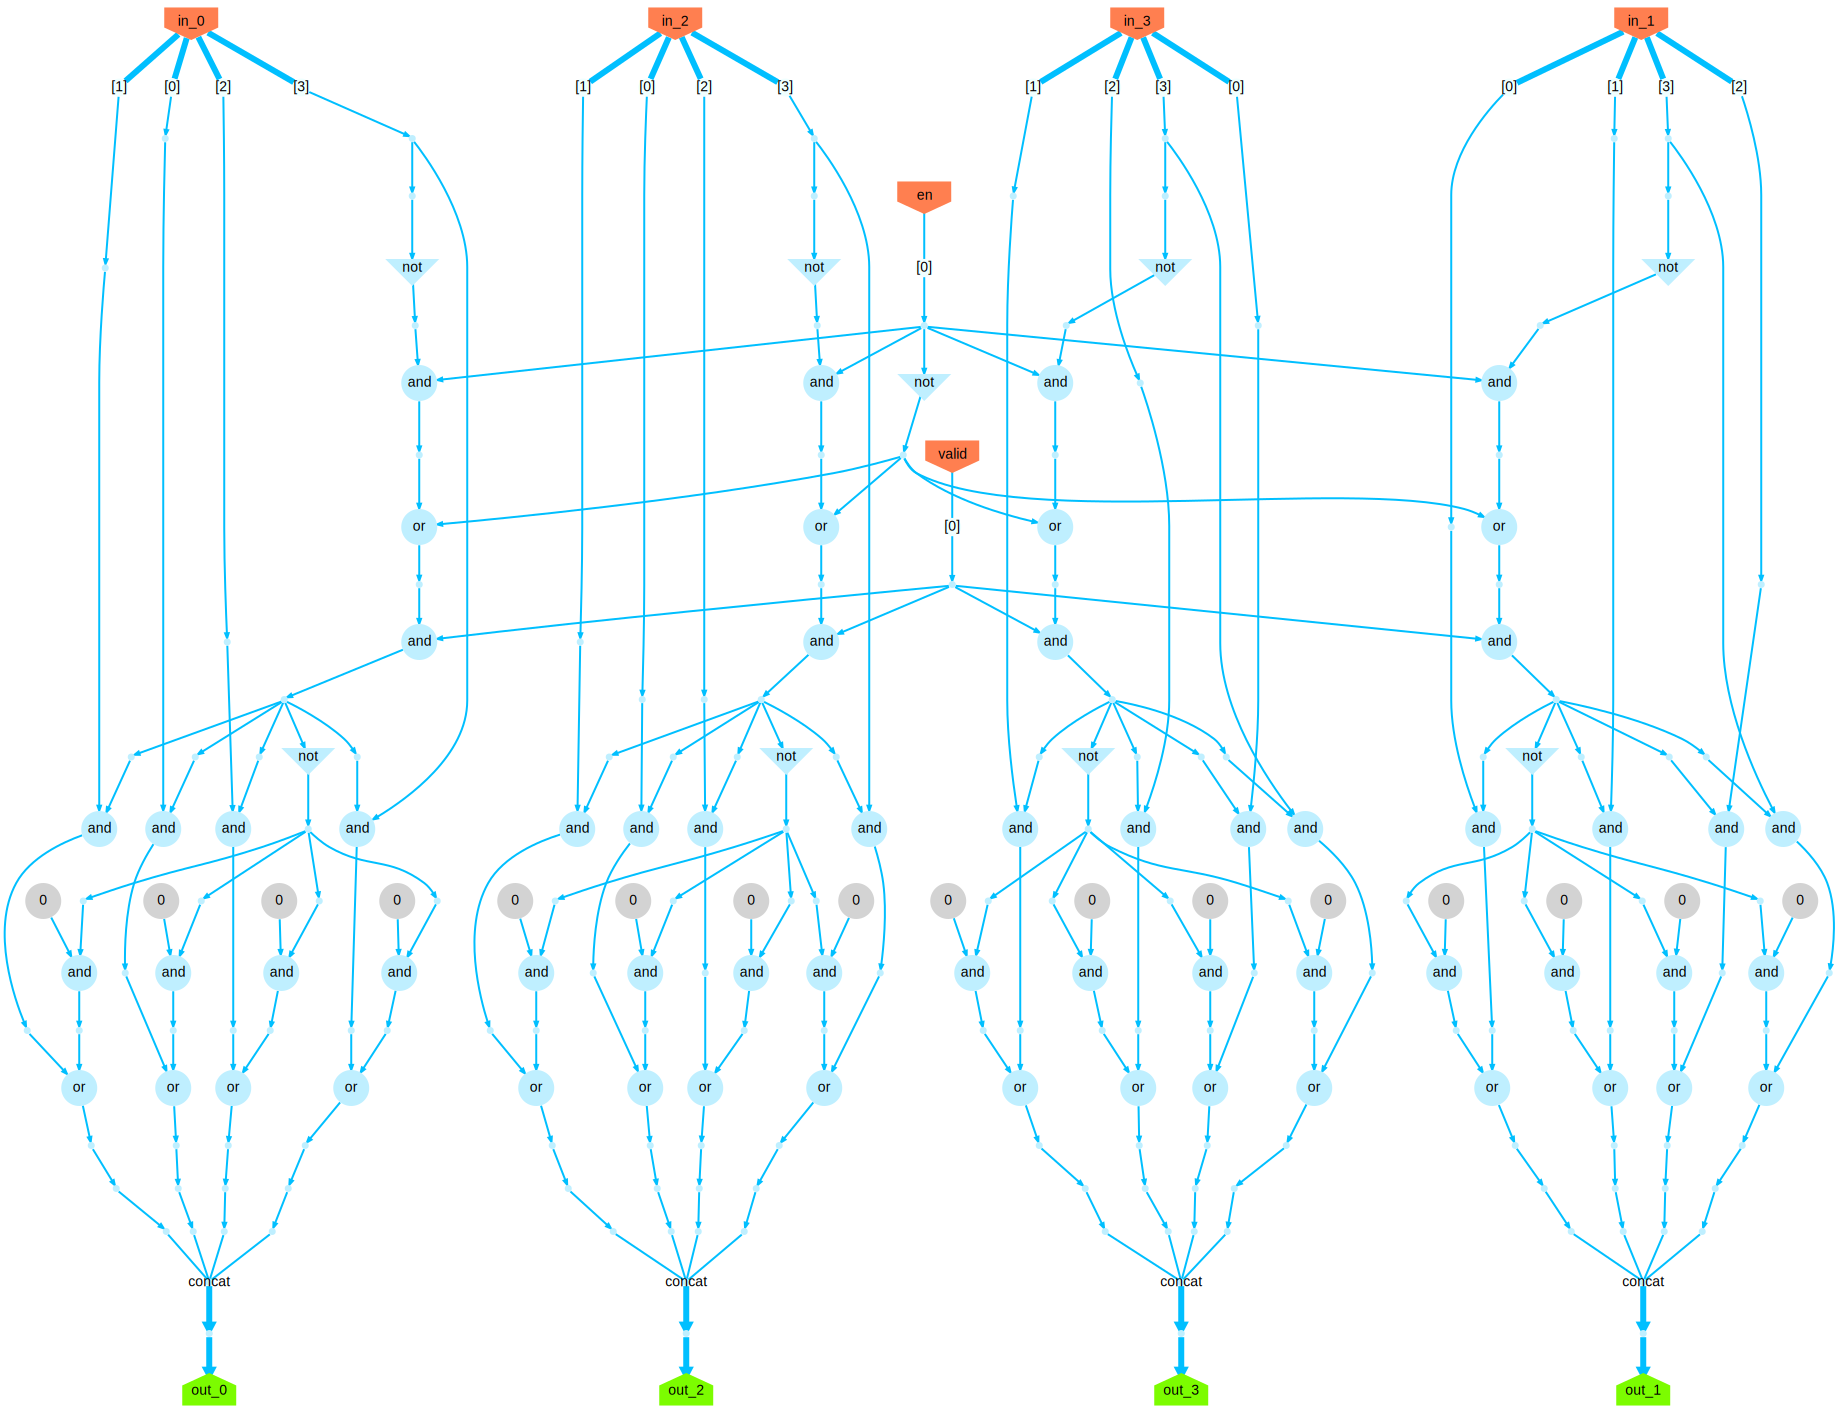

In [ ]:
class FP4:
    def __init__(self, value: float):
        self.value = value

    @classmethod
    def bitwidth(cls):
        return 4


class ReluUnit:
    def __init__(self, size: int, dtype: Type[BaseFloat]):
        self.size = size
        self.dtype = dtype
        self.inputs_valid = WireVector(1)  # indicates if inputs are valid
        self.enable = WireVector(1)  # enable activation function, otherwise passthrough
        self.data = [WireVector(dtype.bitwidth()) for _ in range(size)]
        self.outputs = [self.relu(x) for x in self.data]

    def relu(self, x: WireVector):
        pass_condition = self.inputs_valid & (~self.enable | (self.enable & ~x[-1]))
        return select(pass_condition, x, Const(0, x.bitwidth))

    def connect_inputs(
        self,
        inputs: list[WireVector],
        enable: WireVector,
        valid: WireVector,
    ):
        assert (
            len(inputs) == self.size
        ), f"Activation module input size mismatch. Expected {self.size}, got {len(inputs)}"
        for i in range(self.size):
            self.data[i] <<= inputs[i]
        self.inputs_valid <<= valid
        self.enable <<= enable


reset_working_block()

ins = input_list([f"in_{i}" for i in range(4)], 4)
en = Input(1, "en")
valid = Input(1, "valid")
act = ReluUnit(4, FP4)
act.connect_inputs(ins, en, valid)
outs = output_list([f"out_{i}" for i in range(4)], 4)
for i in range(4):
    outs[i] <<= act.outputs[i]
optimize()
synthesize()
working_block()

In [313]:
timing = TimingAnalysis()

timing.max_freq()

1014.0959334753068